### New TARA datasets.


In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:

from sklearn.datasets import load_svmlight_file
from sklearn.externals import joblib
import argparse
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report

new TARA dataset with 300K combined model

In [5]:
prediction = pd.read_csv('/Users/qingpeng/Dropbox/GeneLearn/TARA/predictions.out2')

In [6]:
prediction_filtered = prediction[prediction.ID != 'ID']

In [7]:
len(prediction_filtered)

7734

In [8]:
len(prediction)

7737

In [9]:
prediction_filtered.dtypes

ID              object
Class           object
Class_id        object
Prob_class_0    object
Prob_class_1    object
Prob_class_2    object
Prob_class_3    object
dtype: object

### there are duplicates contigs id in different files

In [11]:
prediction_filtered.drop_duplicates(subset='ID', keep = 'first',inplace=True)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [12]:
len(prediction_filtered)

7704

In [13]:
### Using MEGAN annotation to check model performance 


from ete2 import NCBITaxa
ncbi = NCBITaxa()
def get_top_label(tax_id):
    lineage = ncbi.get_lineage(tax_id)
    for i in lineage:
        if i == 2759:
            return "Eukaryota"
        elif i == 10239:
            return "Virus"
        elif i == 2157:
            return "Archaea"
        elif i == 2:
            return "Bacteria"
        elif i == 12884:
            return "Viroids"
        elif i == 28384:
            return "other"
        elif i == 12908:
            return "unclassified"
    else:
        return "N/A"

def get_ranks(tax_id):
    ranks = ncbi.get_rank([tax_id])
    try:
        return ranks.values()[0]
    except:
        return tax_id
    
def get_name(tax_id):
    ranks = ncbi.get_taxid_translator([tax_id])
    try:
        return ranks.values()[0]
    except:
        return tax_id

# get MEGAN annotation results

In [14]:
megan_annot = pd.read_csv('/Users/qingpeng/Dropbox/GeneLearn/TARA/diamond-ex.txt',sep='\t',header=None,names=['ID','tax_id'])

megan_annot['rank'] = megan_annot['tax_id'].apply(get_ranks)
megan_annot['tax_name']= megan_annot['tax_id'].apply(get_name)
megan_annot['top_label']= megan_annot['tax_id'].apply(get_top_label)

In [15]:
megan_annot.dtypes

ID           object
tax_id        int64
rank         object
tax_name     object
top_label    object
dtype: object

In [16]:
megan_annot.head()

,ID,tax_id,rank,tax_name,top_label
0,k119_181893,1,no rank,root,N/A
1,k119_203060,1,no rank,root,N/A
2,k119_451532,1,no rank,root,N/A
3,k119_738333,1,no rank,root,N/A
4,k119_105632,1,no rank,root,N/A


In [17]:
len(megan_annot)

6314

In [18]:
megan_annot.drop_duplicates(subset='ID', keep = 'first',inplace=True)

In [19]:
len(megan_annot)

6306

In [20]:
new_table = pd.merge(prediction_filtered,megan_annot,how='left',on='ID')

In [21]:
len(new_table)

7704

In [22]:
new_table['top_label'].fillna('N/A',inplace = True)

### 7704 contigs with length >=3k, in TARA, with prediction


In [23]:
new_table.Prob_class_1 = pd.to_numeric(new_table.Prob_class_1)

### 2130 Contigs with prediction score >0.95

In [24]:
len(new_table[new_table.Prob_class_1>0.95])

2130

### Out of them, 15 are annotated as "Virus" by MEGAN with BlastX/Diamond to Nr database

and 

- 40 Bacteria
- 1738 Eukaryota
- 337 Unknown (no significant Blastx hits)

In [26]:
new_table[new_table.Prob_class_1>0.95].groupby('top_label').size()

top_label
Bacteria       40
Eukaryota    1738
N/A           337
Virus          15
dtype: int64

### If we look at the whole 7704 >3k contigs, most of the contigs are annotated by MEGAN as "Eukaryota"



In [27]:
new_table.groupby('top_label').size()

top_label
Bacteria       83
Eukaryota    6080
N/A          1520
Virus          21
dtype: int64

### 21 Contigs are annotated as "Virus" by MEGAN with BlastX/Diamond to Nr database

In [28]:
new_table[new_table.top_label=='Virus']

,ID,Class,Class_id,Prob_class_0,Prob_class_1,Prob_class_2,Prob_class_3,tax_id,rank,tax_name,top_label
3898,k119_427485,1,1,0.00127287,0.976892,0.00652952,0.015306,1685757.0,species,Lake Sarah-associated circular virus-3,Virus
4179,k119_501378,1,1,0.000254993,0.994904,0.00224289,0.00259795,1888314.0,species,Baker virus,Virus
4512,k119_589941,1,1,1.41583e-05,0.999367,6.60421e-05,0.000553195,10501.0,family,Phycodnaviridae,Virus
4862,k119_686241,1,1,8.80382e-05,0.998129,0.000441553,0.00134152,35278.0,no rank,"ssRNA positive-strand viruses, no DNA stage",Virus
4950,k119_708605,1,1,0.0131083,0.723996,0.185599,0.0772965,1804154.0,species,Marine RNA virus PAL156,Virus
5022,k119_726465,1,1,0.00183943,0.953496,0.010465,0.0341992,10239.0,superkingdom,Viruses,Virus
5443,k119_837204,1,1,0.0126503,0.935475,0.0264514,0.0254237,10239.0,superkingdom,Viruses,Virus
5770,k119_920342,1,1,0.00321086,0.861139,0.104813,0.0308367,35342.0,no rank,unclassified ssDNA viruses,Virus
5827,k119_932436,1,1,0.0585088,0.523020,0.219418,0.199053,10501.0,family,Phycodnaviridae,Virus
5955,k119_968120,1,1,0.00111574,0.943024,0.0427975,0.0130627,10239.0,superkingdom,Viruses,Virus


In [29]:
df_virus = new_table[new_table.top_label=='Virus']

In [30]:
df_Eukaryota = new_table[new_table.top_label=='Eukaryota']
df_Bacteria = new_table[new_table.top_label=='Bacteria']
df_NA = new_table[new_table.top_label=='N/A']


In [36]:
df_Eukaryota

,ID,Class,Class_id,Prob_class_0,Prob_class_1,Prob_class_2,Prob_class_3,tax_id,rank,tax_name,top_label
0,k119_1005,3,3,0.0126593,0.433908,0.0529227,0.50051,33154.0,no rank,Opisthokonta,Eukaryota
1,k119_101107,1,1,4.64833e-05,0.993085,0.000105136,0.00676309,2759.0,superkingdom,Eukaryota,Eukaryota
2,k119_101203,1,1,4.95134e-05,0.997449,4.00037e-05,0.00246167,33154.0,no rank,Opisthokonta,Eukaryota
3,k119_101788,1,1,0.000155943,0.987123,0.00021532,0.012506,33154.0,no rank,Opisthokonta,Eukaryota
4,k119_101818,1,1,0.0131459,0.579407,0.293107,0.11434,33154.0,no rank,Opisthokonta,Eukaryota
5,k119_102004,1,1,7.61004e-05,0.996229,0.000145733,0.00354932,33154.0,no rank,Opisthokonta,Eukaryota
6,k119_102269,3,3,0.000909328,0.386131,0.00145718,0.611503,33154.0,no rank,Opisthokonta,Eukaryota
7,k119_102281,3,3,0.00877491,0.121212,0.0535139,0.816499,33154.0,no rank,Opisthokonta,Eukaryota
8,k119_102615,1,1,6.61113e-05,0.995374,5.38456e-05,0.004506,33154.0,no rank,Opisthokonta,Eukaryota
9,k119_102894,1,1,0.000437542,0.729253,0.00114555,0.269164,33154.0,no rank,Opisthokonta,Eukaryota


In [38]:
df_Eukaryota.sort_values('Prob_class_1', ascending=False)

,ID,Class,Class_id,Prob_class_0,Prob_class_1,Prob_class_2,Prob_class_3,tax_id,rank,tax_name,top_label
29,k119_108647,1,1,1.69974e-12,1.000000e+00,5.03038e-11,4.9411e-08,33154.0,no rank,Opisthokonta,Eukaryota
7113,k119_225454,1,1,4.20113e-10,1.000000e+00,5.28908e-09,2.4834e-07,33154.0,no rank,Opisthokonta,Eukaryota
7037,k119_212021,1,1,8.19584e-10,1.000000e+00,3.28866e-08,1.65346e-07,33154.0,no rank,Opisthokonta,Eukaryota
7347,k119_271011,1,1,5.71357e-13,1.000000e+00,8.43521e-10,1.22749e-08,33154.0,no rank,Opisthokonta,Eukaryota
5889,k119_949389,1,1,3.07339e-09,1.000000e+00,8.63653e-09,2.45578e-07,33154.0,no rank,Opisthokonta,Eukaryota
4555,k119_605657,1,1,3.29013e-09,9.999990e-01,1.25158e-08,8.90831e-07,33154.0,no rank,Opisthokonta,Eukaryota
2048,k119_299578,1,1,4.08282e-11,9.999990e-01,1.22191e-09,1.40156e-06,33154.0,no rank,Opisthokonta,Eukaryota
5056,k119_733518,1,1,2.11921e-08,9.999980e-01,4.96213e-08,1.83841e-06,33630.0,no rank,Alveolata,Eukaryota
6182,k119_19897,1,1,2.19535e-08,9.999970e-01,6.41283e-07,2.67944e-06,33154.0,no rank,Opisthokonta,Eukaryota
3248,k119_78566,1,1,1.55827e-08,9.999970e-01,1.81178e-06,1.07739e-06,33154.0,no rank,Opisthokonta,Eukaryota


### Prediction score distribution of all the 7704 Contigs

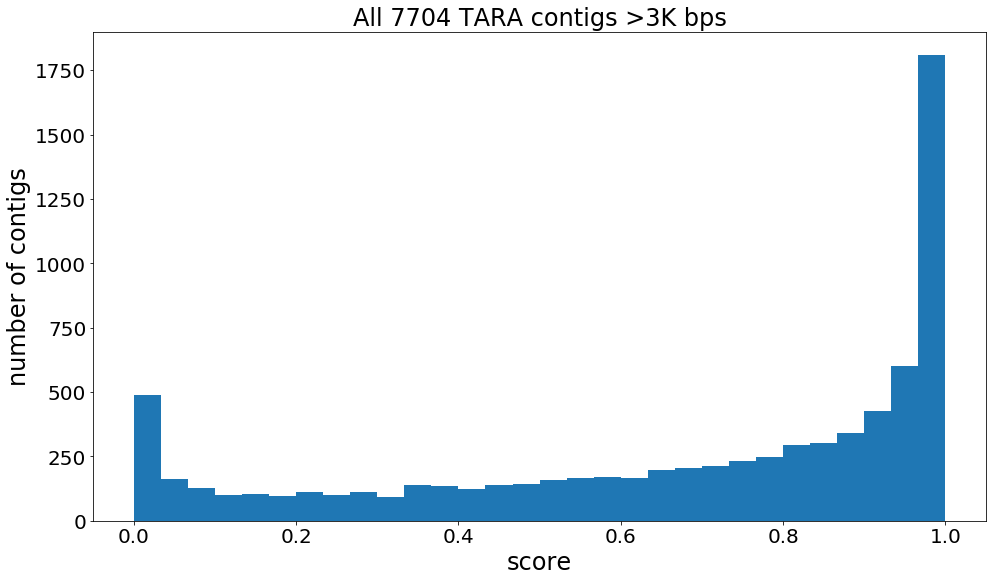

In [31]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 30
#colors = ['red', 'blue', 'grey']
x_multi = [pd.to_numeric(new_table.Prob_class_1)]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus'])
ax0.set_title('All 7704 TARA contigs >3K bps',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)

### Prediction score distribution of the contigs annotated as "Virus", "Eukaryota", "Bacteria", "Unknown" by MEGAN/Blastx

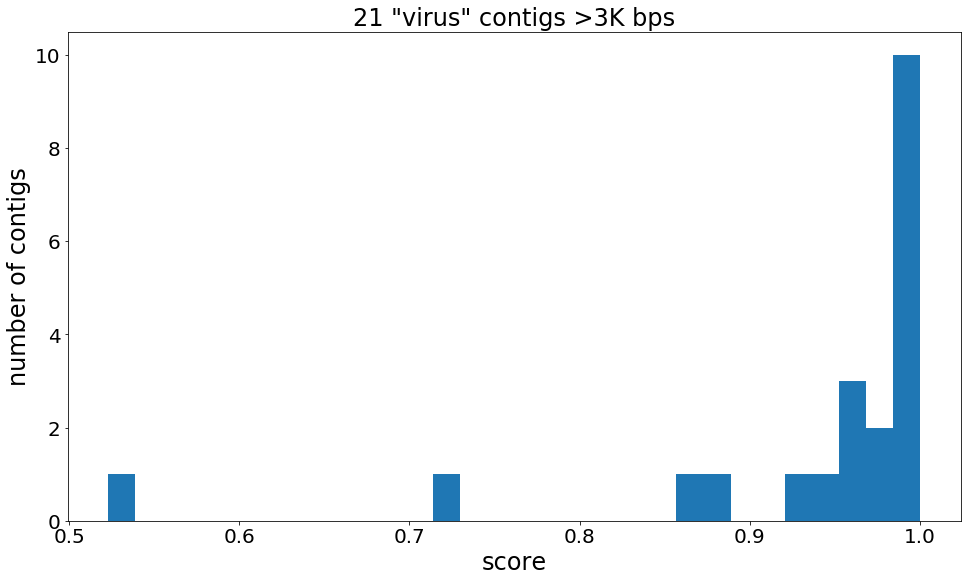

In [32]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 30
#colors = ['red', 'blue', 'grey']
x_multi = [pd.to_numeric(df_virus.Prob_class_1)]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus'])
ax0.set_title('21 \"virus\" contigs >3K bps',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)

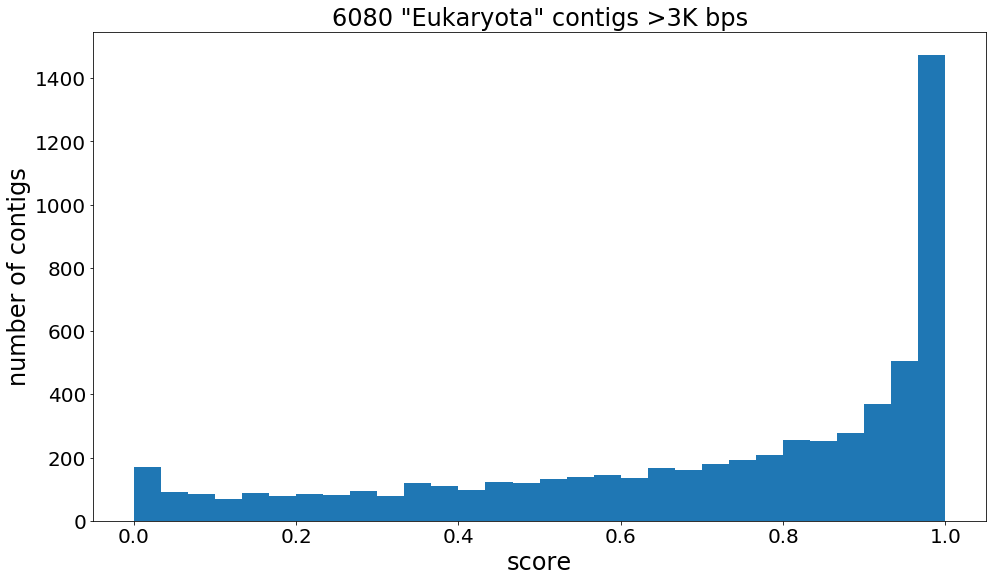

In [33]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 30
#colors = ['red', 'blue', 'grey']
x_multi = [pd.to_numeric(df_Eukaryota.Prob_class_1)]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus'])
ax0.set_title('6080 \"Eukaryota\" contigs >3K bps',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)

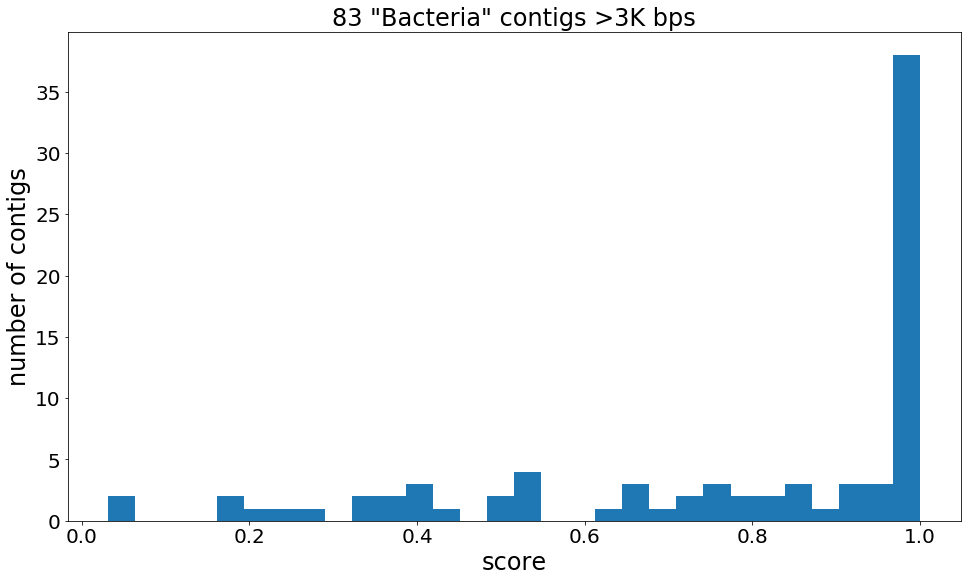

In [34]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 30
#colors = ['red', 'blue', 'grey']
x_multi = [pd.to_numeric(df_Bacteria.Prob_class_1)]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus'])
ax0.set_title('83 \"Bacteria\" contigs >3K bps',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)

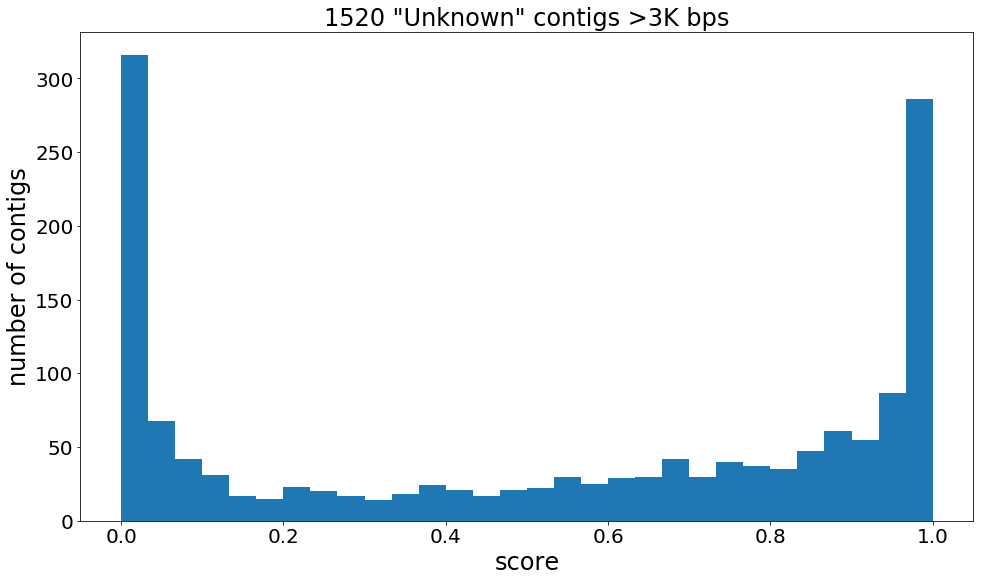

In [35]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 30
#colors = ['red', 'blue', 'grey']
x_multi = [pd.to_numeric(df_NA.Prob_class_1)]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus'])
ax0.set_title('1520 \"Unknown\" contigs >3K bps',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)